In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg
!pip install venn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 44.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 131.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 212.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 162.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 105.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 132.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 210.3 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 142.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 133.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 106.4 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-an

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 194.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py) ... done
  Created wheel for venn: filename=venn-0.1.3-py3-none-any.whl size=19700 sha256=08c29be375218232a0867e8142e7729dacaaac90e757c8c32b006056d34fbb56
  Stored in directory: /tmp/pip-ephem-wheel-cache-y_5zioa4/wheels/9c/ce/43/705b4a04cd822891d1d7a4c43fc444b4798978e72c79528c5f
Successfully built venn


# Comparing E.coli data in BacDrop vs. ProBac

In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

## Read datasets

In [3]:
data_probac = sc.read_h5ad("../data/MOBA_scRNAseq/outs_S1/filtered_data_maxpool_processed.h5ad")
data_bacdrop = sc.read_h5ad("../data/BacDrop/ecoli_data_processed.h5ad")

In [4]:
data_probac.var

,feature_types,genome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,...,nb_umi,Intercept_step1_sct,log_umi_step1_sct,dispersion_step1_sct,mean,std,Locus tag,Protein accession,Name,Symbol
index,,,,,,,,,,,,,,,,,,,,,
aaeA,Gene Expression,PA01,9,0.002953,0.002949,99.734200,10.0,2.397895,9,0.003535,...,2.360024,-8.828138,1.323461,0.058192,-5.678085,0.290888,b3241,NP_417708.1,aromatic carboxylic acid efflux pump membrane ...,aaeA
aaeB,Gene Expression,PA01,2,0.000591,0.000590,99.940933,2.0,1.098612,2,0.000590,...,0.925404,11.580931,-8.667190,0.006412,-4.742895,0.118843,b3240,NP_417707.1,aromatic carboxylic acid efflux pump subunit AaeB,aaeB
aaeR,Gene Expression,PA01,31,0.010041,0.009991,99.084465,34.0,3.555348,31,0.011713,...,2.291489,NaN,NaN,NaN,-4.444255,0.419021,b3243,NP_417710.1,DNA-binding transcriptional activator AaeR,aaeR
aaeX,Gene Expression,PA01,7,0.002363,0.002360,99.793266,8.0,2.197225,7,0.002948,...,2.212363,NaN,NaN,NaN,-5.930263,0.259526,b3242,NP_417709.2,DUF1656 domain-containing protein AaeX,aaeX
aas,Gene Expression,PA01,63,0.020969,0.020752,98.139398,71.0,4.276666,63,0.025254,...,2.425910,-7.019165,1.389573,0.061361,-3.919451,0.535559,b2836,NP_417313.1,fused 2-acylglycerophospho-ethanolamine acyltr...,aas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zraR,Gene Expression,PA01,27,0.008565,0.008528,99.202599,29.0,3.401197,27,0.009673,...,2.434071,-8.674211,1.721170,0.038250,-4.547219,0.398622,b4004,NP_418432.1,DNA-binding transcriptional activator ZraR,zraR
zraS,Gene Expression,PA01,13,0.003839,0.003832,99.616066,13.0,2.639057,13,0.003825,...,2.770594,NaN,NaN,NaN,-5.408301,0.331951,b4003,NP_418431.1,sensor histidine kinase ZraS,zraS
zupT,Gene Expression,PA01,42,0.014471,0.014368,98.759598,49.0,3.912023,42,0.018397,...,2.924372,NaN,NaN,NaN,-4.063312,0.441961,b3040,NP_417512.1,divalent metal ion transporter ZupT,zupT


In [5]:
data_bacdrop.var

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,is_scd_outlier,nb_overdisp,...,highly_variable,highly_variable_rank,means,variances,variances_norm,lt,locus_tag,product_accession,name,symbol
cds-ECs_1431,3,0.003052,0.003047,99.694812,3.0,1.386294,3,0.003043,False,0.178892,...,True,606.0,0.003052,0.003046,0.986901,ECs_1431,NaN,NaN,NaN,NaN
cds-ECs_2321,2,0.002035,0.002033,99.796541,2.0,1.098612,2,0.002030,False,0.119322,...,True,332.0,0.002035,0.002033,0.990919,ECs_2321,NaN,NaN,NaN,NaN
cds-ECs_2323,34,0.034588,0.034003,96.541200,34.0,3.555348,34,0.033393,False,1.412980,...,True,1272.0,0.034588,0.033426,0.829325,ECs_2323,NaN,NaN,NaN,NaN
cds-ECs_2640,3,0.004069,0.004061,99.694812,4.0,1.609438,3,0.006087,False,0.012463,...,True,19.0,0.004069,0.006093,1.473540,ECs_2640,NaN,NaN,NaN,NaN
cds-ECs_2775,3,0.003052,0.003047,99.694812,3.0,1.386294,3,0.003043,False,0.178892,...,True,686.0,0.003052,0.003046,0.986901,ECs_2775,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cds-NP_313381.1,10,0.011190,0.011128,98.982706,11.0,2.484907,10,0.013099,False,0.238025,...,True,140.0,0.011190,0.013113,1.107611,NP_313381.1,ECs_5354,NP_313381.1,transcriptional regulator,rob
cds-NP_313386.1,2,0.002035,0.002033,99.796541,2.0,1.098612,2,0.002030,False,0.119322,...,True,334.0,0.002035,0.002033,0.990919,NP_313386.1,ECs_5359,NP_313386.1,two-component regulatory system response regul...,arcA
cds-YP_009502594.1,17,0.017294,0.017146,98.270600,17.0,2.890372,17,0.016995,False,0.198072,...,True,1196.0,0.017294,0.017012,0.902795,YP_009502594.1,ECs_5391,YP_009502594.1,cytochrome d (bd-I) ubiquinol oxidase subunit X,cydX
cds-YP_009502638.1,2,0.002035,0.002033,99.796541,2.0,1.098612,2,0.002030,False,0.119322,...,True,321.0,0.002035,0.002033,0.990919,YP_009502638.1,ECs_5464,YP_009502638.1,hypothetical protein,yecJ


## Compare raw counts

-> Top 200 cells wrt mean expression per dataset

-> About 50% of genes in common

-> Correlation between expression not ideal

In [6]:
top_genes_probac = data_probac.var.sort_values("total_counts", ascending=False).iloc[:200, :][[
    "n_cells_by_counts", "mean_counts", "total_counts", "pct_dropout_by_counts"
]]
top_genes_bacdrop = data_bacdrop.var.sort_values("total_counts", ascending=False).iloc[:200, :][[
    "n_cells_by_counts", "mean_counts", "total_counts", "pct_dropout_by_counts", "locus_tag", "name", "symbol"
]]

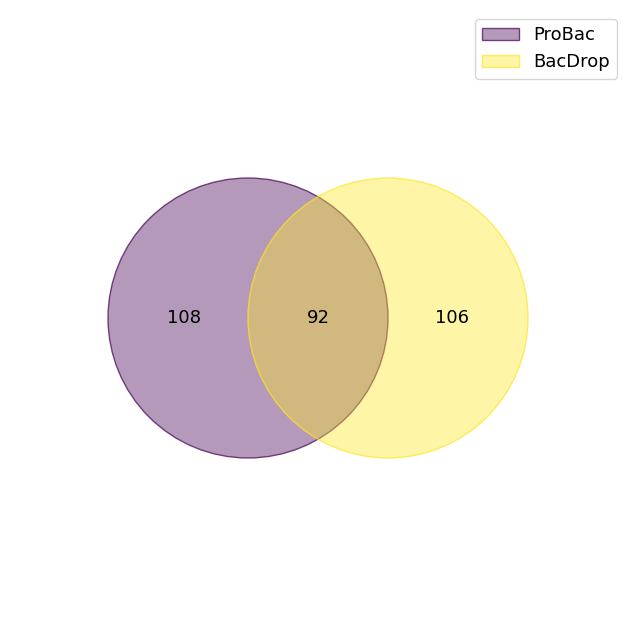

In [7]:
import venn

res_dict = {
    "ProBac": set(top_genes_probac.index.tolist()),
    "BacDrop": set(top_genes_bacdrop["symbol"].tolist()),

}
venn.venn(res_dict)
plt.show()

In [8]:
ranks_probac = pd.DataFrame({
    "rank_probac": np.arange(data_probac.shape[1])}, 
    index=data_probac.var.sort_values("total_counts", ascending=False).index.tolist()
)
bacdrop_high_ex = data_bacdrop.var[data_bacdrop.var["total_counts"] >= 20]
ranks_bacdrop = pd.DataFrame({
    "rank_bacdrop": np.arange(len(bacdrop_high_ex))}, 
    bacdrop_high_ex.sort_values("total_counts", ascending=False)["symbol"].tolist()
)

ranks_bacdrop

,rank_bacdrop
secY,0
fusA,1
rpsN,2
tufB,3
rpoC,4
...,...
prfB,237
fdoG,238
ftsA,239
fabD,240


In [9]:
rank_compare = pd.merge(ranks_probac, ranks_bacdrop, left_index=True, right_index=True, how="outer")
rank_compare = rank_compare[(rank_compare.index.notnull()) & (~rank_compare.index.duplicated(keep='first'))]
rank_compare

,rank_probac,rank_bacdrop
aaeA,2915.0,NaN
aaeB,3852.0,NaN
aaeR,1892.0,NaN
aaeX,3150.0,NaN
aas,1305.0,NaN
...,...,...
zraR,2040.0,NaN
zraS,2709.0,NaN
zupT,1565.0,NaN
zur,1921.0,NaN


In [10]:
top_genes = pd.merge(top_genes_probac, top_genes_bacdrop, left_index=True, right_on="symbol", how="inner", suffixes=("_probac", "_bacdrop"))
top_genes.index = top_genes["symbol"]
top_genes = top_genes[~top_genes.index.duplicated(keep='first')]
top_genes

,n_cells_by_counts_probac,mean_counts_probac,total_counts_probac,pct_dropout_by_counts_probac,n_cells_by_counts_bacdrop,mean_counts_bacdrop,total_counts_bacdrop,pct_dropout_by_counts_bacdrop,locus_tag,name,symbol
symbol,,,,,,,,,,,
rpsE,3011,1.930597,6537.0,11.075015,262,0.363174,357.0,73.346897,ECs_4168,30S ribosomal subunit protein S5,rpsE
rplO,3010,1.911991,6474.0,11.104548,189,0.293998,289.0,80.773143,ECs_4166,50S ribosomal subunit protein L15,rplO
rplE,3064,1.871234,6336.0,9.509746,120,0.170905,168.0,87.792472,ECs_4173,50S ribosomal subunit protein L5,rplE
rplN,2983,1.710573,5792.0,11.901949,37,0.041709,41.0,96.236012,ECs_4175,50S ribosomal subunit protein L14,rplN
rplV,2838,1.572947,5326.0,16.184288,152,0.192269,189.0,84.537131,ECs_4180,50S ribosomal subunit protein L22,rplV
...,...,...,...,...,...,...,...,...,...,...,...
rpoD,616,0.217366,736.0,81.807442,46,0.050865,50.0,95.320448,ECs_3950,RNA polymerase sigma 70 factor RpoD,rpoD
lpxD,594,0.214117,725.0,82.457177,37,0.038657,38.0,96.236012,ECs_0181,UDP-3-O-(3-hydroxymyristoyl)-glucosamine N-acy...,lpxD
lpd,606,0.213822,724.0,82.102776,34,0.036623,36.0,96.541200,ECs_0120,dihydrolipoyl dehydrogenase,lpd


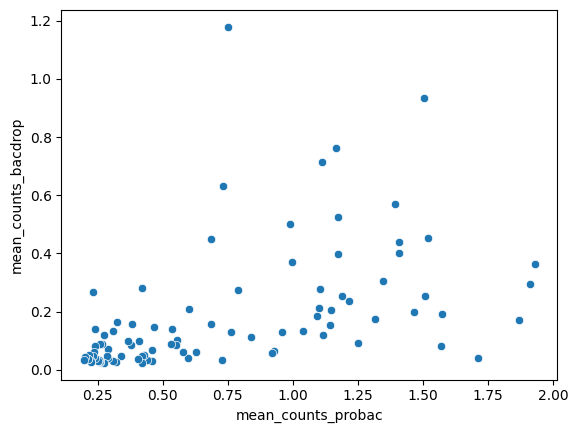

,mean_counts_probac,mean_counts_bacdrop
mean_counts_probac,1.000000,0.667594
mean_counts_bacdrop,0.667594,1.000000


In [11]:
sns.scatterplot(top_genes, x="mean_counts_probac", y="mean_counts_bacdrop")
plt.show()
top_genes[["mean_counts_probac", "mean_counts_bacdrop"]].corr(method="spearman")

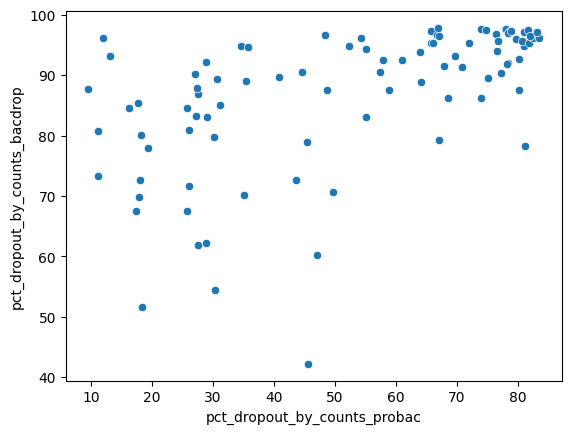

,pct_dropout_by_counts_probac,pct_dropout_by_counts_bacdrop
pct_dropout_by_counts_probac,1.000000,0.448492
pct_dropout_by_counts_bacdrop,0.448492,1.000000


In [12]:
sns.scatterplot(top_genes, x="pct_dropout_by_counts_probac", y="pct_dropout_by_counts_bacdrop")
plt.show()
top_genes[["pct_dropout_by_counts_probac", "pct_dropout_by_counts_bacdrop"]].corr(method="kendall")

<Axes: xlabel='mean_counts', ylabel='Count'>

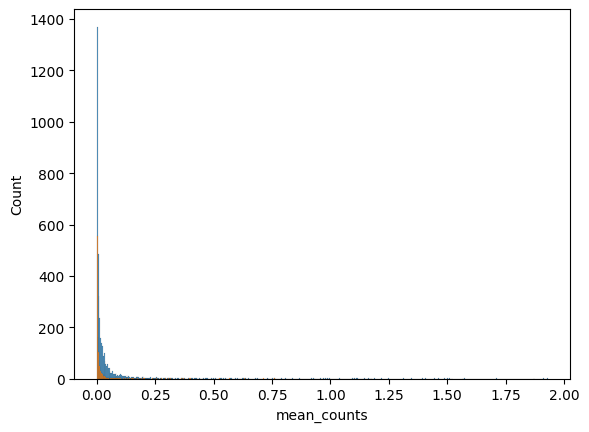

In [13]:
sns.histplot(data_probac.var, x="mean_counts")
sns.histplot(data_bacdrop.var, x="mean_counts")

## Compare VST (not scaled) expressions

In [14]:
data_probac.var["mean_norm_vst"] = np.mean(data_probac.layers["vst_counts"].toarray(), axis=0)
data_bacdrop.var["mean_norm_vst"] = np.mean(data_bacdrop.layers["vst_counts"].toarray(), axis=0)

top_genes_probac_vst = data_probac.var.sort_values("mean_norm_vst", ascending=False).iloc[:200, :][[
    "n_cells_by_counts", "mean_counts", "total_counts", "pct_dropout_by_counts", "mean_norm_vst"
]]
top_genes_bacdrop_vst = data_bacdrop.var.sort_values("mean_norm_vst", ascending=False).iloc[:200, :][[
    "n_cells_by_counts", "mean_counts", "total_counts", "pct_dropout_by_counts", "locus_tag", "name", "symbol", "mean_norm_vst"
]]

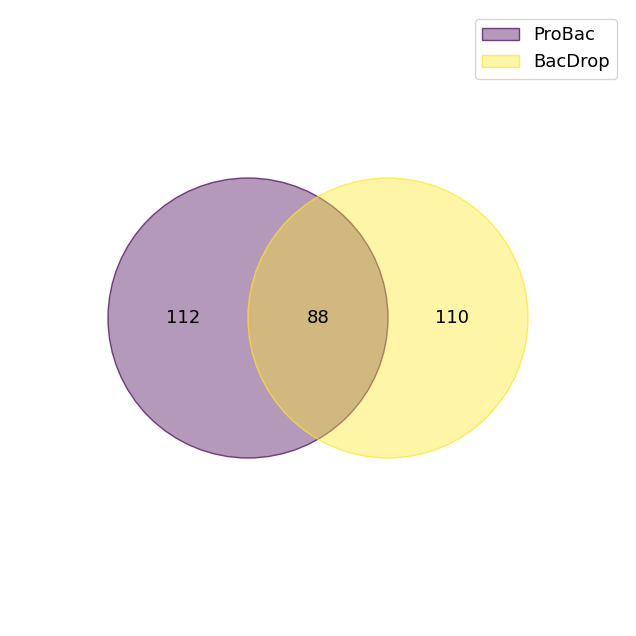

In [15]:
res_dict = {
    "ProBac": set(top_genes_probac_vst.index.tolist()),
    "BacDrop": set(top_genes_bacdrop_vst["symbol"].tolist()),

}
venn.venn(res_dict)
plt.show()

In [16]:
top_genes_vst = pd.merge(top_genes_probac_vst, top_genes_bacdrop_vst, left_index=True, right_on="symbol", how="inner", suffixes=("_probac", "_bacdrop"))
top_genes_vst.index = top_genes_vst["symbol"]
top_genes_vst = top_genes_vst[~top_genes_vst.index.duplicated(keep='first')]
top_genes_vst

,n_cells_by_counts_probac,mean_counts_probac,total_counts_probac,pct_dropout_by_counts_probac,mean_norm_vst_probac,n_cells_by_counts_bacdrop,mean_counts_bacdrop,total_counts_bacdrop,pct_dropout_by_counts_bacdrop,locus_tag,name,symbol,mean_norm_vst_bacdrop
symbol,,,,,,,,,,,,,
rplX,2943,1.567927,5309.0,13.083284,3.194360,67,0.082401,81.0,93.184130,ECs_4174,50S ribosomal subunit protein L24,rplX,-0.421847
rplE,3064,1.871234,6336.0,9.509746,3.145373,120,0.170905,168.0,87.792472,ECs_4173,50S ribosomal subunit protein L5,rplE,-1.112008
rpsE,3011,1.930597,6537.0,11.075015,3.139408,262,0.363174,357.0,73.346897,ECs_4168,30S ribosomal subunit protein S5,rpsE,0.909163
rplN,2983,1.710573,5792.0,11.901949,3.107185,37,0.041709,41.0,96.236012,ECs_4175,50S ribosomal subunit protein L14,rplN,-0.780227
rplO,3010,1.911991,6474.0,11.104548,2.979534,189,0.293998,289.0,80.773143,ECs_4166,50S ribosomal subunit protein L15,rplO,0.496291
...,...,...,...,...,...,...,...,...,...,...,...,...,...
aceF,651,0.230951,782.0,80.773774,-0.633217,43,0.048830,48.0,95.625636,ECs_0119,pyruvate dehydrogenase,aceF,-1.621434
spoT,557,0.199646,676.0,83.549911,-0.682059,37,0.042726,42.0,96.236012,ECs_4525,bifunctional (p)ppGpp synthase/hydrolase SpoT,spoT,-0.871218
glgC,569,0.197283,668.0,83.195511,-0.688096,18,0.018311,18.0,98.168871,ECs_4275,glucose-1-phosphate adenylyltransferase,glgC,-1.489656


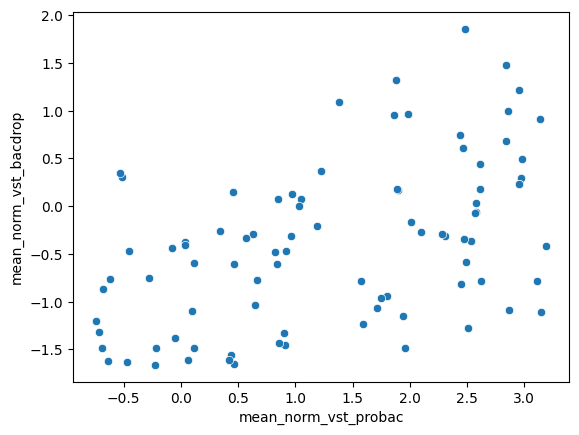

,mean_norm_vst_probac,mean_norm_vst_bacdrop
mean_norm_vst_probac,1.000000,0.491811
mean_norm_vst_bacdrop,0.491811,1.000000


In [17]:
sns.scatterplot(top_genes_vst, x="mean_norm_vst_probac", y="mean_norm_vst_bacdrop")
plt.show()
top_genes_vst[["mean_norm_vst_probac", "mean_norm_vst_bacdrop"]].corr(method="spearman")

<Axes: xlabel='mean_norm_vst', ylabel='Count'>

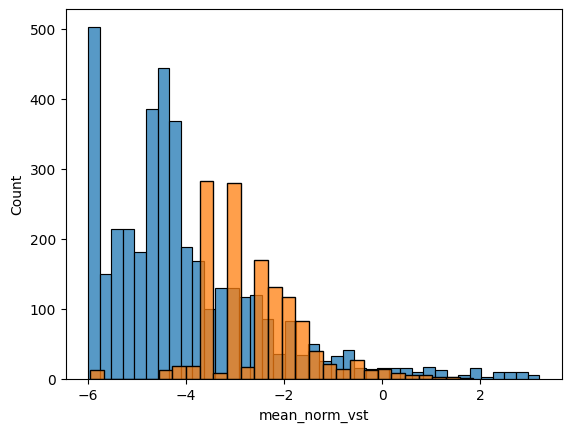

In [18]:
sns.histplot(data_probac.var, x="mean_norm_vst")
sns.histplot(data_bacdrop.var, x="mean_norm_vst")

## Gene-wise expression correlation

In [19]:
data_bacdrop.var_names

Index(['cds-ECs_1431', 'cds-ECs_2321', 'cds-ECs_2323', 'cds-ECs_2640',
       'cds-ECs_2775', 'cds-ECs_2921', 'cds-ECs_3109', 'cds-ECs_3559',
       'cds-ECs_3848', 'cds-ECs_3860',
       ...
       'cds-NP_313373.1', 'cds-NP_313374.1', 'cds-NP_313376.1',
       'cds-NP_313377.2', 'cds-NP_313380.1', 'cds-NP_313381.1',
       'cds-NP_313386.1', 'cds-YP_009502594.1', 'cds-YP_009502638.1',
       'cds-YP_009502653.1'],
      dtype='object', length=1301)

In [20]:
common_genes = list(set(data_probac.var_names).intersection(set(data_bacdrop.var["symbol"])))
len(common_genes)

data_probac_intersect = data_probac[:, common_genes]
data_bacdrop_intersect = data_bacdrop[:, data_bacdrop.var["symbol"].isin(common_genes)]
data_probac_intersect

View of AnnData object with n_obs × n_vars = 3386 × 1064
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std', 'Locus tag', 'Protein accession', 'Name', 'Symbol', 'mean_norm_vst'
    uns: 'BacSC_params', 'embedding_reliability_colors', 'leiden_opt', 'leiden_opt_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'connectivities', 'distances'

In [21]:
gene_corr_raw = spearmanr(
    data_probac_intersect.layers["counts"].toarray(),
    data_bacdrop_intersect.layers["counts"].toarray(),
    axis=1
)
print(gene_corr_raw)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1064 and the array at index 1 has size 1071